In [37]:
from typing import Any, Dict, List

import duckdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


def set_attr(conn: duckdb.DuckDBPyConnection) -> None:
    conn.execute("SET max_memory='64GB';")
    conn.execute("SET threads=4;")
    conn.execute("SET enable_progress_bar=1;")
    conn.execute("SET temp_directory = 'C:/Projet/tmp/';")
    conn.execute("SET disable_parquet_prefetching = TRUE;")
    conn.execute("SET parquet_metadata_cache = TRUE;")


def decorate_df(df: pd.DataFrame, caption: str):
    return (
        df.style.set_caption(caption)
        .set_table_styles(
            [
                {
                    "selector": "caption",
                    "props": [("caption-side", "top"), ("font-size", "1.25em")],
                },
                {"selector": "th", "props": [("text-align", "center")]},
                {"selector": "th.row_heading", "props": [("text-align", "right")]},
                {
                    "selector": "td:hover",
                    "props": [("background-color", "#ffff99"), ("color", "black")],
                },
                {
                    "selector": "table",
                    "props": [
                        ("border", "1px solid black"),
                        ("border-collapse", "collapse"),
                    ],
                },
                {
                    "selector": "th, td",
                    "props": [("border", "1px solid black")],
                },
            ],
            overwrite=False,
        )
        .format(
            precision=2,
            thousands=" ",
            na_rep="",
        )
        .set_sticky(axis=0)
        .set_sticky(axis=1)
    )


seed = 42

In [2]:
def _build_projection(mapping: Dict[str, Dict[str, Any]]) -> str:
    """Return the SELECT list that converts invalid values to NULL and applies alias/type."""
    parts = []
    for raw, info in mapping.items():
        alias = info["alias"]
        inval = info.get("invalid", [])
        typ = info["type"]

        if not inval:
            parts.append(f"CAST({raw} AS {typ}) AS {alias}")
            continue
        elif not isinstance(inval, (list, tuple)):
            inval = [inval]

        # Proper quoting for string invalids
        in_list = ", ".join(f"'{v}'" if isinstance(v, str) else str(v) for v in inval)
        parts.append(
            f"CAST(CASE WHEN {raw} IN ({in_list}) THEN NULL ELSE {raw} END AS {typ}) AS {alias}"
        )
    return ",\n       ".join(parts)


def extract(
    conn: duckdb.DuckDBPyConnection,
    parquet_path: str,
    mapping: Dict[str, Dict[str, Any]],
    *,
    show=False,
) -> None:
    """Read Parquet, clean invalid values, and create stg.transactions."""
    projection = _build_projection(mapping)

    conn.execute("CREATE SCHEMA IF NOT EXISTS stg")
    conn.execute("DROP TABLE IF EXISTS stg.transactions")

    conn.execute(
        f"""
        CREATE TABLE stg.transactions AS
        SELECT {projection}
        FROM read_parquet('{parquet_path}');
        """
    )

    if show:
        conn.table("stg.transactions").show(max_rows=40)


In [3]:
import json

with open("columns_map.json", "r", encoding="utf-8") as f:
    columns_map = json.load(f)

In [18]:
with duckdb.connect(database="projet.db", read_only=False) as conn:
    set_attr(conn)
    extract(conn, "C:\Projet\Raw_data\A202401.parquet", columns_map, show=True)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────┬──────────────────────────┬──────────────────┬─────────────────────────┬──────────────────┬─────────────────────────┬───────────────────────────────┬──────────────────────┬─────────────────┬────────────────┬───────────────────────────┬───────────────────────────────┬─────────────────────────┬────────────────┬─────────────────────────┬────────────────────┬────────────────────────────┬───────────────────────────┬─────────────────────┬──────────────────────────┬─────────────────────┬──────────────────────┬──────────────────────────────┬──────────────────────────────┬────────────────────────┬───────────────┬────────────────────────────┬──────────────┬───────────────────────┬─────────────────────┬────────────────────┬────────────────────────┬─────────────────────┬───────────────────────────┬──────────────────────┬──────────────────────────┬────────────────┬───────────────┐
│ dep_honoraire │ tranche_age_bénéficiaire │ nature_assurance │ nature_accident_travail │ top_bénéfici

In [5]:
def exploratoire(
    conn: duckdb.DuckDBPyConnection,
    stg_table: str,
    columns_map: Dict[str, Dict[str, Any]],
    *,
    show: bool = False,
) -> duckdb.DuckDBPyRelation:
    """Compute per‑column null statistics after extract()."""
    conn.execute(
        """
        CREATE OR REPLACE TABLE stg.exploratoire (
            column_name TEXT,
            nb_total BIGINT,
            nb_inutilisables BIGINT,
            pct_inutilisables DOUBLE
        );
        """
    )

    for meta in columns_map.values():
        if not meta.get("invalid"):
            continue
        col = meta["alias"]
        conn.execute(
            f"""
            INSERT INTO stg.exploratoire
            SELECT
                '{col}',
                COUNT(*) AS nb_total,
                COUNT(*) FILTER (WHERE {col} IS NULL) AS nb_inutilisables,
                ROUND(nb_inutilisables / nb_total, 6) AS pct_inutilisables
            FROM {stg_table};
            """
        )

    if show:
        conn.table("stg.exploratoire").show(max_rows=40)
    else:
        return conn.table("stg.exploratoire")

In [19]:
with duckdb.connect(database="projet.db", read_only=False) as conn:
    set_attr(conn)
    exploratoire(conn, "stg.transactions", columns_map, show=True)

┌───────────────────────────────┬──────────┬──────────────────┬───────────────────┐
│          column_name          │ nb_total │ nb_inutilisables │ pct_inutilisables │
│            varchar            │  int64   │      int64       │      double       │
├───────────────────────────────┼──────────┼──────────────────┼───────────────────┤
│ tranche_age_bénéficiaire      │ 38758176 │            40558 │          0.001046 │
│ nature_assurance              │ 38758176 │                1 │               0.0 │
│ nature_accident_travail       │ 38758176 │         38745854 │          0.999682 │
│ top_bénéficiaire              │ 38758176 │         34312781 │          0.885304 │
│ qualité_du_bénéficiaire       │ 38758176 │                7 │               0.0 │
│ région_résidence_bénéficiaire │ 38758176 │          2427121 │          0.062622 │
│ sexe_du_bénéficiaire          │ 38758176 │                0 │               0.0 │
│ complément_acte               │ 38758176 │                0 │             

In [19]:
def impute_nulls_with_mode(
    conn: duckdb.DuckDBPyConnection, table: str, columns: List[str]
) -> None:
    for col in columns:
        mode_query = (
            f"SELECT mode({col}) AS mode_val FROM {table} WHERE {col} IS NOT NULL"
        )
        mode_val = conn.execute(mode_query).fetchone()[0]

        if mode_val is not None:
            update_query = f"""
                UPDATE {table}
                SET {col} = {mode_val}
                WHERE {col} IS NULL
            """
            conn.execute(update_query)


def add_index(
    conn: duckdb.DuckDBPyConnection, table: str, index_name: str, seed: int = 42
) -> None:
    import math

    conn.execute(f"ALTER TABLE {table} ADD COLUMN IF NOT EXISTS {index_name} UTINYINT")

    conn.execute(f"SELECT SETSEED({math.tanh(seed)})")

    conn.execute(f"""
    UPDATE {table}
    SET {index_name} = floor(random()*10)::UTINYINT
    WHERE {index_name} IS NULL
""")


def feature_engineering(
    conn: duckdb.DuckDBPyConnection,
    X_cols: List[str],
    Y_cols: List[str],
    columns_map: Dict[str, Dict[str, Any]],
    from_table: str,
    to_table: str,
    new_features: Dict[str, List[str]],
    index_name: str,
) -> None:
    for _, meta in columns_map.items():
        alias = meta["alias"]
        category = meta["category"]
        if alias in X_cols and category in new_features.keys():
            new_features[category].append(alias)

    concat_sql_parts = []
    for feature, value in new_features.items():
        if value:
            concat_sql_parts.append(f"CONCAT_WS('_', {', '.join(value)}) AS {feature}")

    conn.execute(f"""
        CREATE OR REPLACE TABLE {to_table} AS 
        SELECT {",".join(concat_sql_parts + Y_cols)}, {index_name}
        FROM {from_table}""")


In [26]:
threshold = 0.2
stg_table = "stg.transactions"
concat_table = "stg.transactions_concated"
index_name = "index"

with duckdb.connect(database="projet.db", read_only=False) as conn:
    set_attr(conn)
    extract(conn, "C:\Projet\Raw_data\A202401.parquet", columns_map)

    X_cols = (
        exploratoire(conn, stg_table, columns_map)
        .filter(f"pct_inutilisables < {threshold}")
        .project("column_name")
        .to_df()["column_name"]
        .tolist()
    )
    Y_cols = ["dep_honoraire"]

    impute_nulls_with_mode(conn, stg_table, X_cols)
    add_index(conn, stg_table, index_name)
    """
    new_features = {
        "BENEFICIAIRE": [],
        "PRESTATION": [],
        "EXECUTANT": [],
        "PRESCRIPTEUR": [],
        "ORGANISME": [],
        "PERIODE": [],
    }

    feature_engineering(
        conn,
        X_cols,
        Y_cols,
        columns_map,
        stg_table,
        concat_table,
        new_features,
        index_name,
    )

    X_cols = list(new_features.keys())"""

    X = (
        conn.table(stg_table)
        .filter(f"{index_name} = 0")
        .select(*X_cols)
        .fetch_arrow_table()
        .to_pandas(split_blocks=True)
    )
    X = X.astype({col: "category" for col in X_cols})
    y = (
        conn.table(stg_table)
        .filter(f"{index_name} = 0")
        .select(*Y_cols)
        .fetch_arrow_table()
        .to_pandas()
    ).squeeze()

    print(X.shape, y.shape)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

(3875293, 16) (3875293,)


In [10]:
import pprint

from boruta import BorutaPy
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted


class BorutaFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, estimator, output=False):
        self.estimator = estimator
        self.output = output

    def fit(self, X, y):
        self.feature_names_ = X.columns.tolist()
        self.selector = BorutaPy(
            estimator=self.estimator,
            n_estimators="auto",
            max_iter=10,
            random_state=seed,
        )
        self.selector.fit(X.values, y)
        self._sklearn_is_fitted = True
        if self.output:
            self._show_ranking()

        return self

    def transform(self, X):
        check_is_fitted(self, attributes=["selector"])
        return X.iloc[:, self.selector.support_]

    def _show_ranking(self):
        print("------Support and Ranking for each feature------")
        feature_info = [
            (self.selector.support_[i], self.selector.ranking_[i], feature)
            for i, feature in enumerate(self.feature_names_)
        ]
        feature_info.sort(key=lambda x: (x[1], x[2]))
        digit = len(str(len(self.feature_names_)))

        for support, ranking, feature in feature_info:
            status = "✅" if support else "❌"
            print(f"{status} Rank: {ranking:<{digit}} - {feature}")

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split

with duckdb.connect(database="projet.db", read_only=False) as conn:
    set_attr(conn)
    for i in range(5):
        query = f"""
            SELECT {", ".join(X_cols + Y_cols)}
            FROM {stg_table}
            USING SAMPLE 100000 ROWS
        """
        query_result = (
            conn.execute(query).fetch_arrow_table().to_pandas(split_blocks=True)
        )

        X_tiny = query_result[X_cols].astype({col: "category" for col in X_cols})
        y_tiny = query_result[Y_cols].squeeze()

        X_train_tiny, X_test_tiny, y_train_tiny, y_test_tiny = train_test_split(
            X_tiny, y_tiny, test_size=0.2, random_state=seed
        )

        # Boruta Feature Selection
        rf = BorutaFeatureSelector(
            estimator=ExtraTreesClassifier(n_jobs=-1),
            output=True,
        )
        rf.fit(X_train_tiny, y_train_tiny)

------Support and Ranking for each feature------
✅ Rank: 1  - code_qualificatif_parcours
❌ Rank: 2  - tranche_age_bénéficiaire
❌ Rank: 3  - catégorie_exécutant
❌ Rank: 4  - région_ps_exécutant
❌ Rank: 5  - région_résidence_bénéficiaire
❌ Rank: 6  - région_organisme_liquidation
❌ Rank: 7  - catégorie_du_prescripteur
❌ Rank: 8  - sexe_du_bénéficiaire
❌ Rank: 9  - mois_de_soins
❌ Rank: 10 - année_de_soins
❌ Rank: 11 - qualité_du_bénéficiaire
❌ Rank: 12 - code_secteur
❌ Rank: 13 - statut_juridique_ps
❌ Rank: 14 - nature_assurance
❌ Rank: 15 - complément_acte
❌ Rank: 16 - type_prise_en
------Support and Ranking for each feature------
✅ Rank: 1  - code_qualificatif_parcours
❌ Rank: 2  - tranche_age_bénéficiaire
❌ Rank: 3  - catégorie_exécutant
❌ Rank: 4  - région_ps_exécutant
❌ Rank: 5  - région_résidence_bénéficiaire
❌ Rank: 6  - région_organisme_liquidation
❌ Rank: 7  - catégorie_du_prescripteur
❌ Rank: 8  - sexe_du_bénéficiaire
❌ Rank: 9  - mois_de_soins
❌ Rank: 10 - année_de_soins
❌ Rank

In [27]:
X = X.loc[:, "code_qualificatif_parcours"]
X = X.to_frame()
print(X.shape)

(3875293, 1)


In [35]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV
from tabulate import tabulate


def optimize_hyperparameters(
    X,
    y,
    estimator,
    param_distributions,
    *,
    scoring="accuracy",
    n_jobs=-1,
    cv=5,
    random_state=42,
) -> RandomizedSearchCV:
    """Optimize hyperparameters using RandomizedSearchCV."""
    randomized_search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=param_distributions,
        scoring=scoring,
        n_jobs=n_jobs,
        cv=cv,
        return_train_score=True,
        random_state=random_state,
    )
    randomized_search.fit(X, y)
    return randomized_search.best_estimator_, randomized_search.best_params_


def plot_confusion_matrix(
    estimator, X_train, y_train, X_test, y_test, title="Confusion Matrix"
):
    report_train = classification_report(
        y_train, estimator.predict(X_train), output_dict=True, zero_division=0
    )
    report_test = classification_report(
        y_test, estimator.predict(X_test), output_dict=True, zero_division=0
    )

    df_train = pd.DataFrame(report_train).T
    df_test = pd.DataFrame(report_test).T

    df_combined = pd.concat(
        [df_train, df_test],
        axis=1,
        keys=["Train", "Test"],
    )

    idx = df_combined.index.get_loc("accuracy")
    df_combined = pd.concat(
        [
            df_combined.iloc[:idx],
            pd.DataFrame(
                [[np.nan] * len(df_combined.columns)],
                columns=df_combined.columns,
                index=["\u200b"],
            ),
            df_combined.iloc[idx:],
        ]
    )

    for t1 in ["Train", "Test"]:
        for t2 in ["precision", "recall"]:
            df_combined.at["accuracy", (t1, t2)] = np.nan
        df_combined.at["accuracy", (t1, "support")] = df_combined.at[
            "macro avg", (t1, "support")
        ]

    display(
        decorate_df(
            df_combined,
            f"Confusion Matrix of {title} (Train/Test)",
        )
    )

    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    axs = axs.flatten()

    ConfusionMatrixDisplay.from_estimator(
        estimator, X_train, y_train, ax=axs[0], text_kw={"fontsize": 28}, colorbar=False
    )
    ConfusionMatrixDisplay.from_estimator(
        estimator, X_test, y_test, ax=axs[1], text_kw={"fontsize": 28}, colorbar=False
    )

    axs[0].set_title("Train")
    axs[1].set_title("Test")
    plt.tight_layout()
    plt.suptitle(f"Confusion Matrix of {title}", fontsize=24, y=0.78)
    plt.show()

In [30]:
from lightgbm import LGBMClassifier
from scipy.stats import randint, uniform

param_distributions = {
    "model__num_leaves": randint(20, 150),  # Controls tree complexity
    "model__max_depth": randint(3, 15),  # Limits tree depth
    "model__learning_rate": uniform(0.01, 0.3),  # Step size shrinkage
    "model__n_estimators": randint(100, 1000),  # Number of boosting rounds
    "model__min_child_samples": randint(5, 100),  # Minimum data in one leaf
    "model__subsample": uniform(0.5, 0.5),  # Subsample ratio of the training instance
    "model__colsample_bytree": uniform(
        0.5, 0.5
    ),  # Subsample ratio of columns when constructing each tree
    "model__reg_alpha": uniform(0.0, 1.0),  # L1 regularization term
    "model__reg_lambda": uniform(0.0, 1.0),  # L2 regularization term
}

model = LGBMClassifier(random_state=seed)

model.fit(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

best_model, _ = optimize_hyperparameters(
    X_train,
    y_train,
    model,
    param_distributions,
    scoring="accuracy",
    n_jobs=-1,
    cv=5,
    random_state=seed,
)

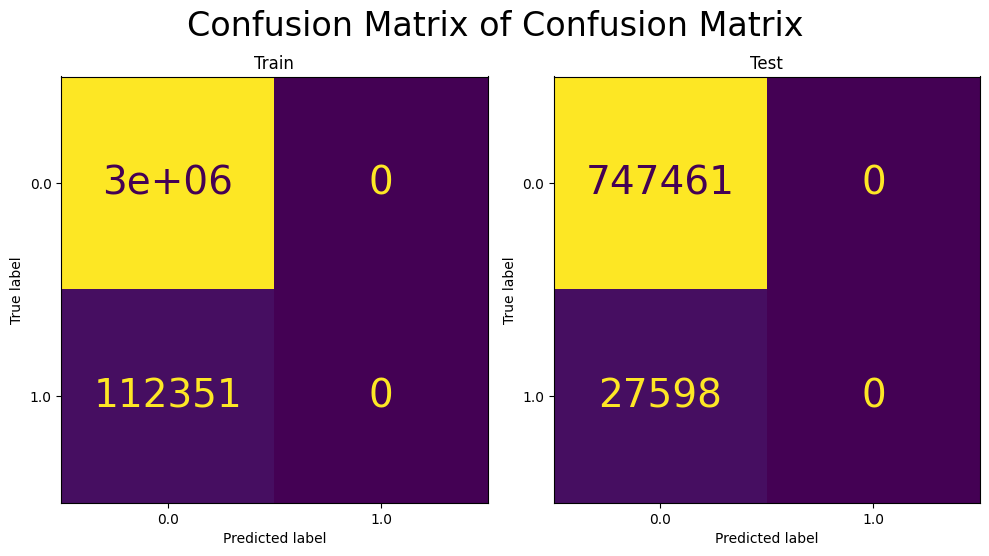

In [38]:
plot_confusion_matrix(
    best_model,
    X_train,
    y_train,
    X_test,
    y_test,
)
